## Objective
This notebook performs a detailed analysis of the apartment dataset to understand how each feature relates to price. We examine categorical variables such as city, neighborhood, and amenities to assess distributions and encoding strategies, and explore numeric variables like area, number of rooms, bathrooms, and building age to detect outliers and relationships with price. The insights from this analysis will guide feature selection, transformations, and preparation for modeling with tree-based regressors.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arabic_reshaper
from bidi.algorithm import get_display
from scipy import stats

plt.rcParams['font.family'] = ['Arial Unicode MS', 'Tahoma', 'Arial', 'sans-serif']

In [3]:
df = pd.read_csv("Apartments.csv", encoding = 'utf-8-sig')
df.head(10)
df_og = df.copy()

**To collect as much data as possible, the scraper will be re-run periodically to gather new listings. To avoid scraping the same apartment multiple times, we need to check for duplicates and remove them.**

In [4]:
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 101


In [5]:
df = df.drop_duplicates()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 848 entries, 0 to 908
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   السعر بالشيكل   848 non-null    object
 1   المدينة         848 non-null    object
 2   الحي / المنطقة  848 non-null    object
 3   عدد الغرف       848 non-null    int64 
 4   عدد الحمامات    848 non-null    int64 
 5   مفروشة          848 non-null    int64 
 6   مساحة البناء    848 non-null    int64 
 7   الطابق          848 non-null    object
 8   عمر البناء      848 non-null    int64 
 9   العقار مرهون    848 non-null    object
 10  طريقة الدفع     848 non-null    int64 
 11  مصعد            848 non-null    object
 12  موقف سيارات     848 non-null    object
dtypes: int64(6), object(7)
memory usage: 92.8+ KB


### Data Conversions

In [7]:
# convert price to integer values
df['السعر بالشيكل'] = df["السعر بالشيكل"].astype(str).str.replace('"', '', regex=False).str.replace(",", "", regex=False)
df['السعر بالشيكل'] = pd.to_numeric(df['السعر بالشيكل'])
df.head(1)

,السعر بالشيكل,المدينة,الحي / المنطقة,عدد الغرف,عدد الحمامات,مفروشة,مساحة البناء,الطابق,عمر البناء,العقار مرهون,طريقة الدفع,مصعد,موقف سيارات
0,397476,نابلس,المخفية,3,2,0,138,2,2,F,0,T,T


In [8]:
# Map T/F to True/False boolean values
bool_map = {'T': True, 'F': False}
pd.set_option('future.no_silent_downcasting', True)
for col in ["العقار مرهون", "مصعد", "موقف سيارات"]:
    df[col] = df[col].replace({'T': True, 'F': False}).astype(bool)
df.head(1)

,السعر بالشيكل,المدينة,الحي / المنطقة,عدد الغرف,عدد الحمامات,مفروشة,مساحة البناء,الطابق,عمر البناء,العقار مرهون,طريقة الدفع,مصعد,موقف سيارات
0,397476,نابلس,المخفية,3,2,0,138,2,2,False,0,True,True


### Handling arabic text
Since Matplotlib has limited support for rendering Arabic text, a reshaper function will be used to ensure proper display.

In [9]:
def process_arabic_text(text):
    if isinstance(text, str):
        reshaped_text = arabic_reshaper.reshape(text)
        return get_display(reshaped_text)
    return text

### Outlier Removal
To clean the dataset, we calculated the price per square meter for each listing and detected outliers separately for each city using the Interquartile Range (IQR) method. Cities with very few listings used the global distribution as a fallback. Outliers were then removed to ensure that extreme prices do not skew the analysis, while fairly priced large apartments remain in the dataset.

In [10]:
prices = df['السعر بالشيكل']
areas = df['مساحة البناء']
price_per_sqm = prices / areas

min_count = 20
outlier_mask = pd.Series(False, index=df.index)

for city, group in df.groupby('المدينة'):
    vals = price_per_sqm.loc[group.index]
    q1 = vals.quantile(0.25)
    q3 = vals.quantile(0.75)
    iqr = q3 - q1
    
    # Cities with fewer than 100 listings use the global quartiles instead of per-city IQR
    if len(group) < min_count:
        global_q1 = price_per_sqm.quantile(0.25)
        global_q3 = price_per_sqm.quantile(0.75)
        q1, q3 = global_q1, global_q3
        iqr = q3 - q1

    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    mask = (vals < lower) | (vals > upper)

    if mask.any():
        print(f"\nOutliers in {city}:")
        print(group.loc[mask]
              .assign(سعر_للمتر=vals[mask])
              [["المدينة", "مساحة البناء", 'السعر بالشيكل', 'سعر_للمتر']]
              .sort_values('سعر_للمتر', ascending=False)
              .head(10))

    outlier_mask.loc[group.index] |= mask

print("\nTotal outliers found:", outlier_mask.sum())
df = df.loc[~outlier_mask].copy()


Outliers in الخليل:
    المدينة  مساحة البناء  السعر بالشيكل     سعر_للمتر
686  الخليل           170        2614973  15382.194118
688  الخليل           100         522995   5229.950000
242  الخليل           110         470695   4279.045455
11   الخليل           110         470695   4279.045455
784  الخليل           110          40000    363.636364
732  الخليل           650         180000    276.923077

Outliers in القدس:
    المدينة  مساحة البناء  السعر بالشيكل     سعر_للمتر
345   القدس           142       10000000  70422.535211
104   القدس           107        1650000  15420.560748

Outliers in بيت لحم:
     المدينة  مساحة البناء  السعر بالشيكل     سعر_للمتر
771  بيت لحم            85        1112880  13092.705882
653  بيت لحم            70         575294   8218.485714

Outliers in جنين:
    المدينة  مساحة البناء  السعر بالشيكل    سعر_للمتر
662    جنين            30         261497  8716.566667

Outliers in رام الله والبيرة:
              المدينة  مساحة البناء  السعر بالشيكل      سعر_ل

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 781 entries, 0 to 908
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   السعر بالشيكل   781 non-null    int64 
 1   المدينة         781 non-null    object
 2   الحي / المنطقة  781 non-null    object
 3   عدد الغرف       781 non-null    int64 
 4   عدد الحمامات    781 non-null    int64 
 5   مفروشة          781 non-null    int64 
 6   مساحة البناء    781 non-null    int64 
 7   الطابق          781 non-null    object
 8   عمر البناء      781 non-null    int64 
 9   العقار مرهون    781 non-null    bool  
 10  طريقة الدفع     781 non-null    int64 
 11  مصعد            781 non-null    bool  
 12  موقف سيارات     781 non-null    bool  
dtypes: bool(3), int64(7), object(3)
memory usage: 69.4+ KB


### Feature Correlation with Price

In this step, we assess how each feature relates to the target variable **السعر بالشيكل**.

- **مساحة البناء** is fully numeric, so we use **Pearson correlation** to measure linear relationships.
- **عدد الغرف**, **عدد الحمامات**, and **عمر البناء** are quasi-categorical, so we use **Spearman correlation** to capture monotonic relationships.

This analysis helps identify which features are most strongly associated with price and informs feature selection for modeling.

In [12]:
features_continuous = ["مساحة البناء"]
features_quasi_categorical = ["عدد الغرف", "عدد الحمامات", "عمر البناء"]

summary = {}

# Pearson for continuous
for col in features_continuous:
    summary[col] = df[col].corr(df["السعر بالشيكل"], method='pearson')

# Spearman for quasi-categorical
for col in features_quasi_categorical:
    summary[col] = df[col].corr(df["السعر بالشيكل"], method='spearman')

summary_series = pd.Series(summary).sort_values(key=abs, ascending=False)

print("\n--- Correlation with Price ---")
print(summary_series.round(3))



--- Correlation with Price ---
مساحة البناء    0.730
عدد الحمامات    0.474
عدد الغرف       0.095
عمر البناء     -0.071
dtype: float64


The correlation results show that area and number of bathrooms have the strongest relationship with price, so we’ll inspect these more closely.

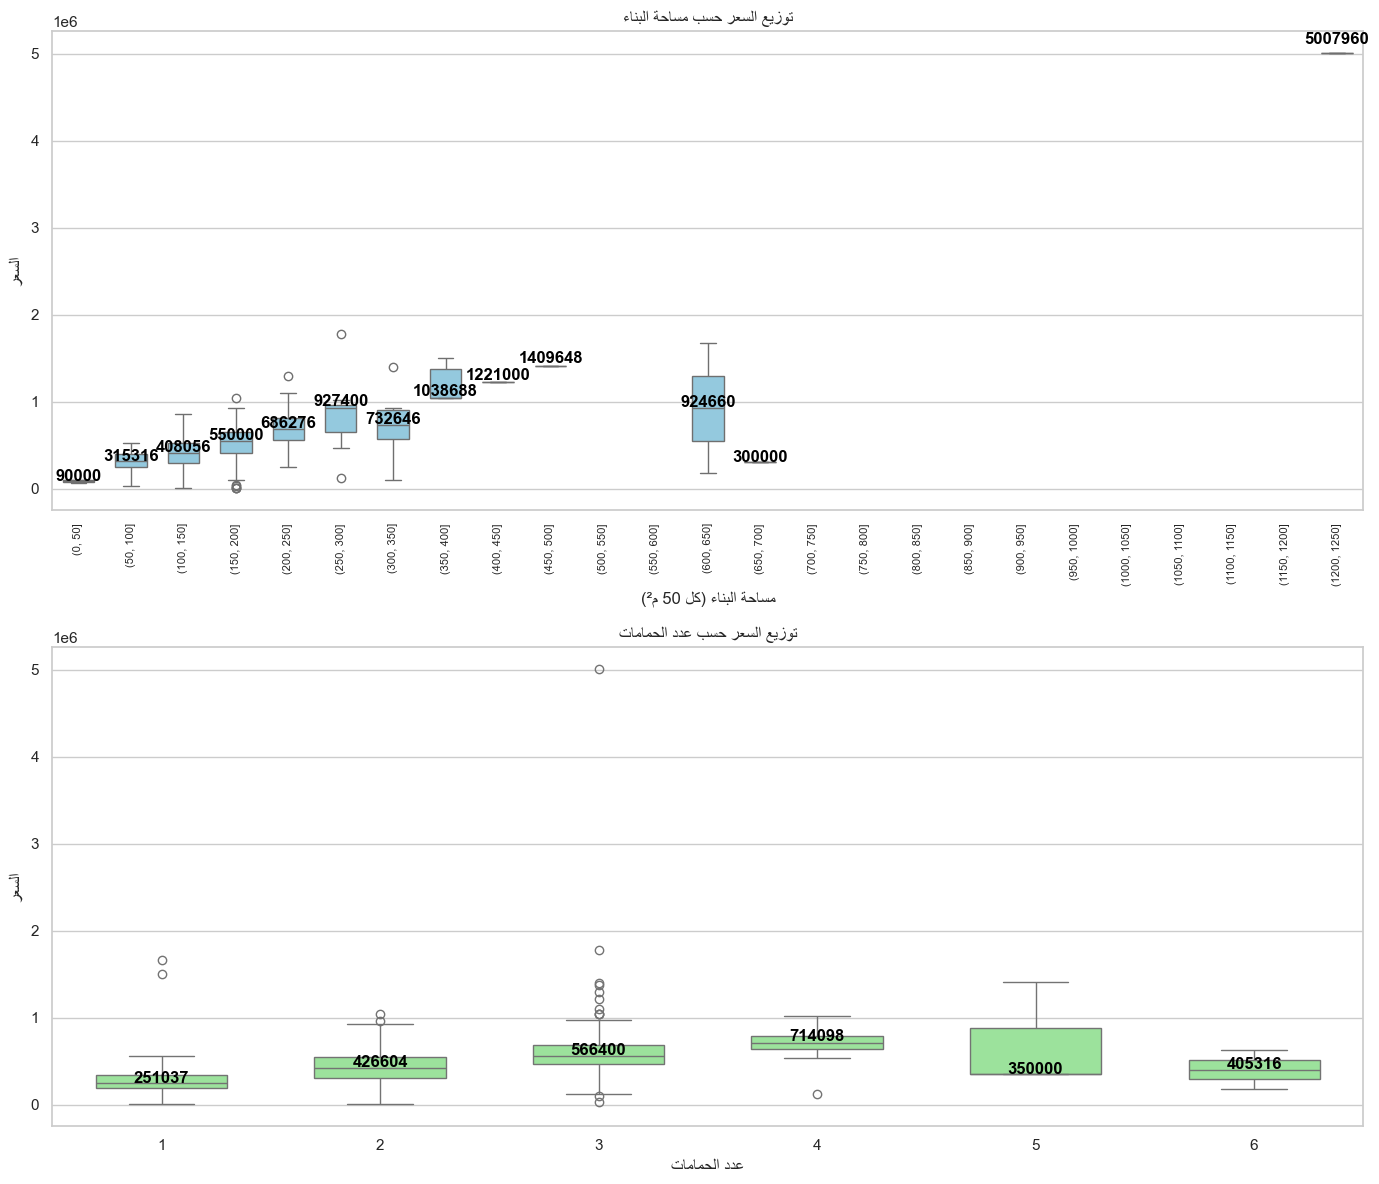

In [13]:
sns.set(style="whitegrid", font_scale=1.0)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))  # 2 rows, 1 column

# --- Area (binned) vs Price ---
df["area_bin"] = pd.cut(
    df["مساحة البناء"],
    bins=np.arange(0, df["مساحة البناء"].max() + 50, 50)
)

valid_bins = df["area_bin"].value_counts().index
df_area = df[df["area_bin"].isin(valid_bins)]

sns.boxplot(x="area_bin", y="السعر بالشيكل", data=df_area, ax=ax1, color="skyblue", width=0.6)
ax1.set_xlabel(process_arabic_text("مساحة البناء (كل 50 م²)"))
ax1.set_ylabel(process_arabic_text("السعر"))
ax1.set_title(process_arabic_text("توزيع السعر حسب مساحة البناء"))
ax1.tick_params(axis="x", rotation=90, labelsize=8)

medians_area = df_area.groupby("area_bin", observed=False)["السعر بالشيكل"].median()
for i, median in enumerate(medians_area):
    ax1.text(i, median + median * 0.02, f"{median:.0f}",
             ha='center', color='black', weight='semibold')

# --- Bathrooms vs Price ---
sns.boxplot(x="عدد الحمامات", y="السعر بالشيكل", data=df, ax=ax2, color="lightgreen", width=0.6)
ax2.set_xlabel(process_arabic_text("عدد الحمامات"))
ax2.set_ylabel(process_arabic_text("السعر"))
ax2.set_title(process_arabic_text("توزيع السعر حسب عدد الحمامات"))

medians_bath = df.groupby("عدد الحمامات", observed=False)["السعر بالشيكل"].median()
for i, median in enumerate(medians_bath):
    ax2.text(i, median + median * 0.02, f"{median:.0f}",
             ha='center', color='black', weight='semibold')

plt.tight_layout()
plt.show()

df.drop(columns=["area_bin"], inplace=True)


In [13]:
#drop the clear outlier from area
df = df[~((df['مساحة البناء'] >= 650))]

### Category Counts & Cardinality Check
This will be useful to keep in mind when it comes to augmentaion and data synthesis, so we can know the distribution to try and maintain

In [14]:
floor_mapping = {
    'G': 0,  # ارضي
    'B': -1, # شبه ارضي
    'P': -2,  # التسوية
    'R': 11 # Roof
}
df['الطابق'] = df['الطابق'].replace(floor_mapping)

df['الطابق'] = pd.to_numeric(df['الطابق'])


Feature: المدينة
Value counts:
  رام الله والبيرة: 472
  نابلس: 111
  بيت لحم: 64
  الخليل: 33
  جنين: 29
  القدس: 27
  طولكرم: 27
  أريحا: 6
  سلفيت: 5
  قلقيلية: 4
  طوباس: 1

Total unique values: 11
Most common: رام الله والبيرة (472 occurrences)
Least common: طوباس (1 occurrences)


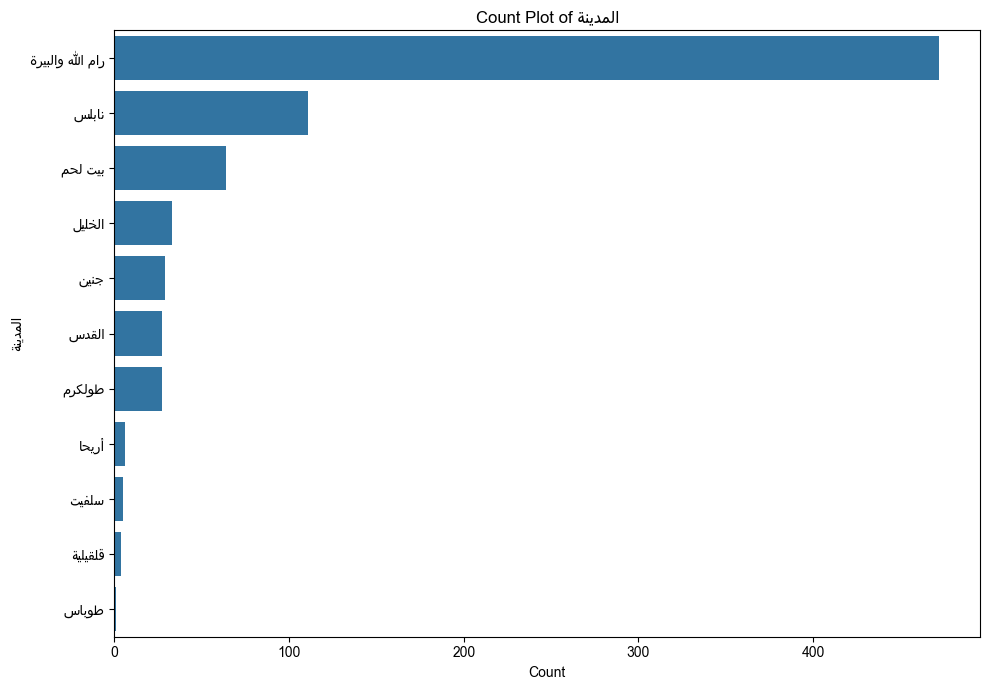


Feature: الحي / المنطقة
Value counts:
  الطيرة: 89
  بيتونيا: 62
  البالوع: 40
  الماصيون: 35
  عين مصباح: 35
  سطح مرحبا: 25
  ش. الارسال: 25
  أخرى: 24
  عين منجد: 24
  رفيديا: 21
  بيت جالا: 18
  الجبل الشمالي: 17
  بير زيت: 17
  ضاحية الريحان: 16
  ام الشرايط: 15
  سردا: 15
  التحتا: 11
  بطن الهوى: 11
  ش. القدس: 11
  الدوحة: 11
  وسط البلد: 11
  كفر عقب: 9
  الجبل الجنوبي: 9
  دار صلاح: 9
  بيت ايبا: 8
  روابي: 8
  ش. حيفا: 7
  حي المعاجين: 6
  ابو ديس: 6
  الحرس: 6
  بيت ساحور: 6
  المخفية: 6
  الشرفة: 5
  نابلس الجديدة: 5
  الحي الشمالي: 5
  الخضر: 4
  ش. التعاون: 4
  ش. نابلس: 4
  شويكة: 4
  الحي الشرقي: 4
  جناتا: 4
  صانور: 3
  الجامعة الامريكية: 3
  حي البساتين: 3
  الجنيد: 3
  دورا: 3
  ش. تل: 3
  المساكن الشعبية: 3
  المنطقة الصناعية الشرقية: 3
  الجابريات: 3
  الحي الجنوبي: 3
  بير نبالا: 3
  ش. عمان: 3
  جفنا: 3
  عقبة تفوح: 3
  الحاووز الثاني: 2
  بيت وزن: 2
  ذنابة: 2
  جبل الرحمة: 2
  ش. المنتزه: 2
  حزما: 2
  مراح السعد: 2
  واد التفاح: 2
  ش. الصف: 2
  الحاووز الا

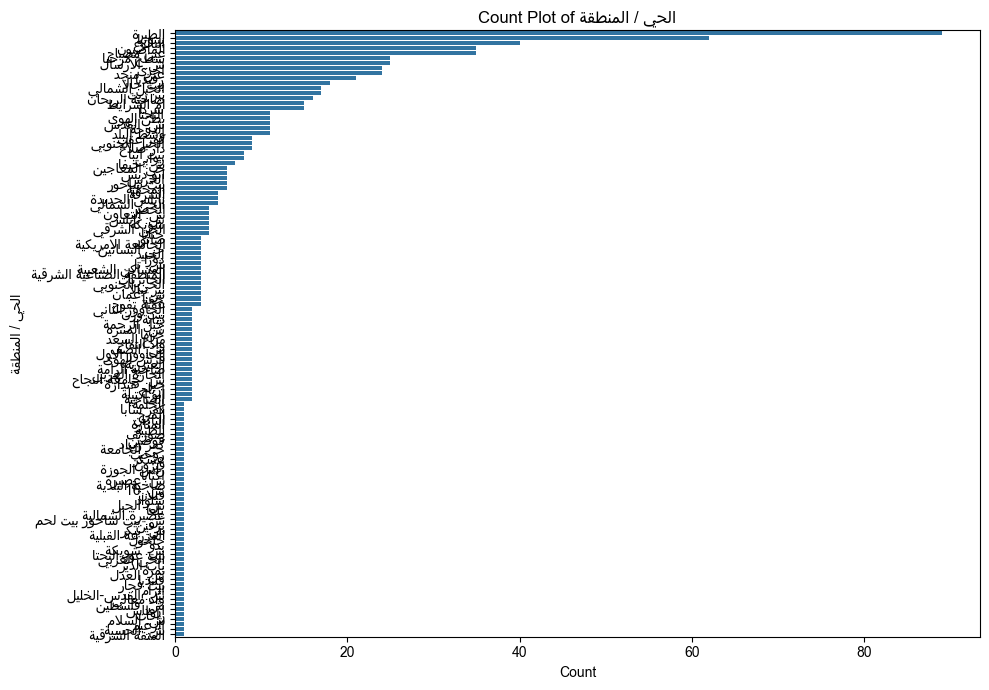


Feature: مفروشة
Value counts:
  0: 631
  1: 116
  2: 32

Total unique values: 3
Most common: 0 (631 occurrences)
Least common: 2 (32 occurrences)


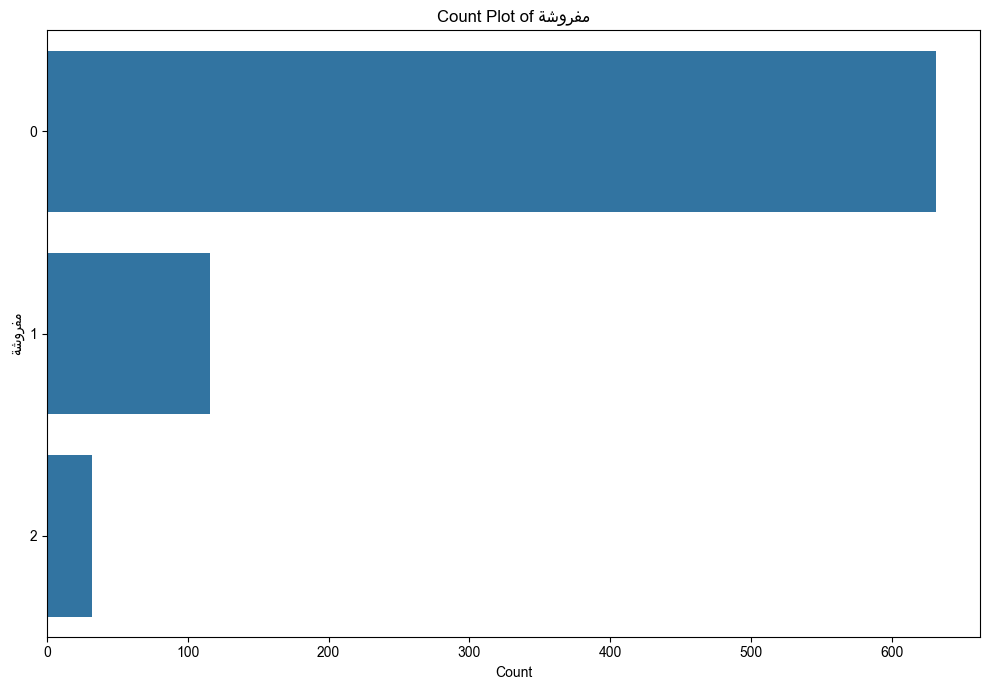


Feature: العقار مرهون
Value counts:
  False: 762
  True: 17

Total unique values: 2
Most common: False (762 occurrences)
Least common: True (17 occurrences)


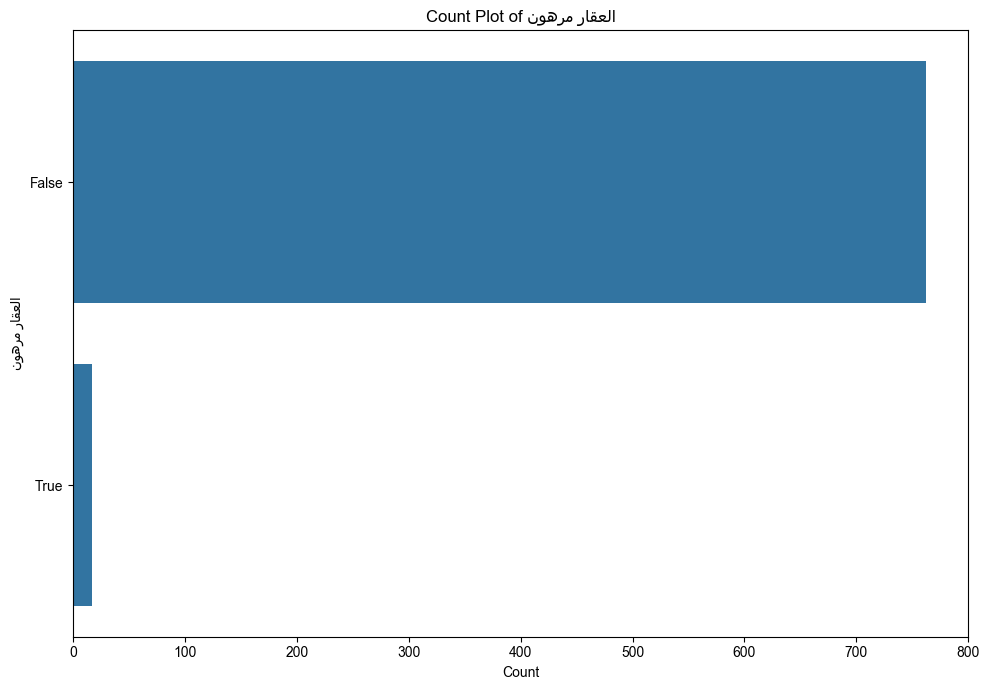


Feature: مصعد
Value counts:
  True: 476
  False: 303

Total unique values: 2
Most common: True (476 occurrences)
Least common: False (303 occurrences)


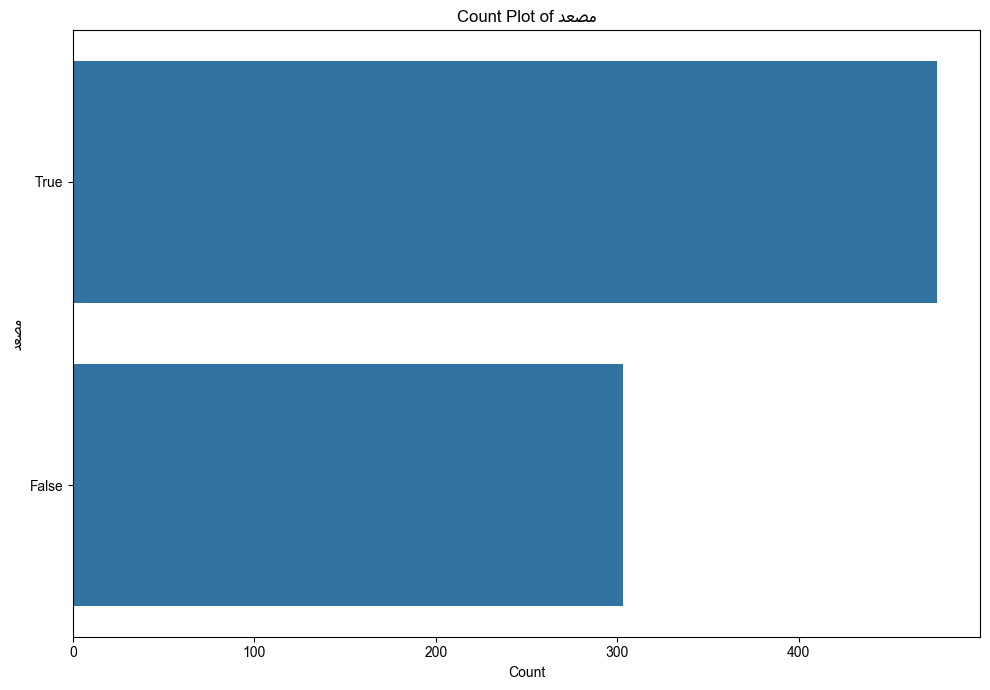


Feature: موقف سيارات
Value counts:
  True: 468
  False: 311

Total unique values: 2
Most common: True (468 occurrences)
Least common: False (311 occurrences)


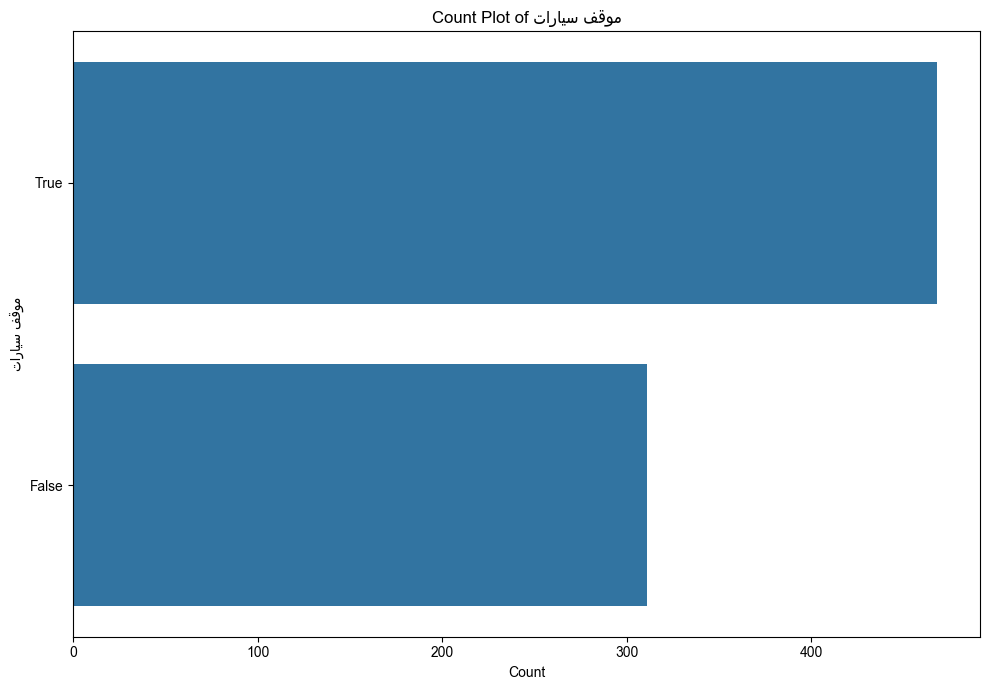


Feature: الطابق
Value counts:
  4: 156
  1: 138
  3: 134
  2: 114
  0: 91
  5: 31
  6: 30
  -1: 29
  11: 17
  7: 12
  -2: 11
  8: 6
  9: 6
  10: 4

Total unique values: 14
Most common: 4 (156 occurrences)
Least common: 10 (4 occurrences)


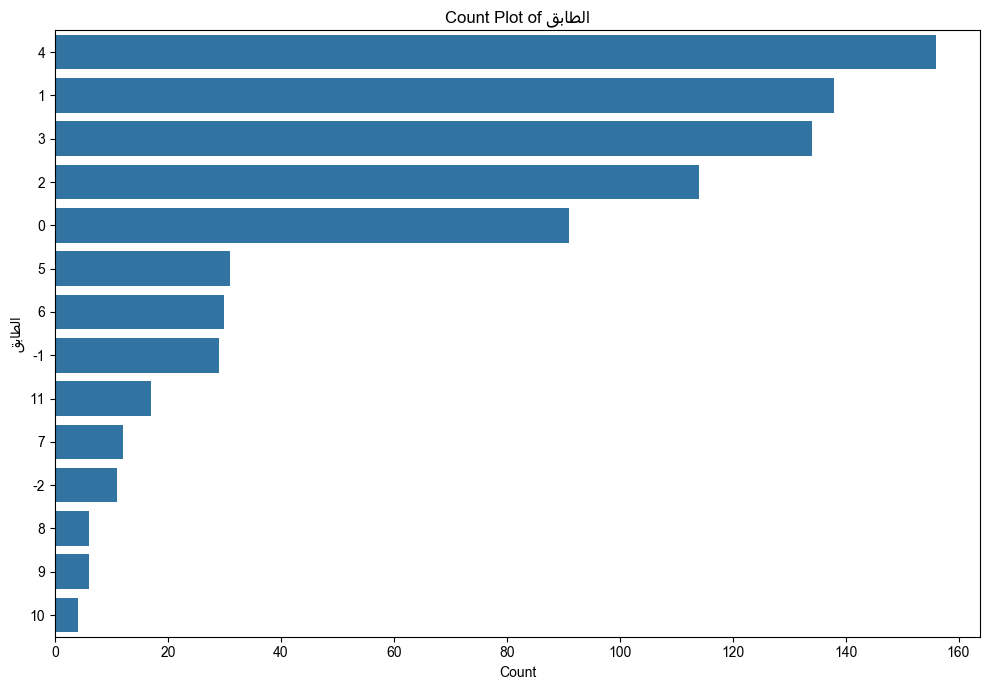

In [15]:
# Manually define the list of categorical features including the newly corrected ones
categorical_features = ['المدينة', 'الحي / المنطقة', 'مفروشة', 'العقار مرهون', 'مصعد', 'موقف سيارات', 'الطابق']

# Create count plots for each of these features
for feature in categorical_features:
    print(f"\n{'='*50}")
    print(f"Feature: {feature}")
    print(f"{'='*50}")
    
    # Use value_counts() to get both the feature values and their counts, then sort by count
    counts = df[feature].value_counts()
    
    print("Value counts:")
    for value, count in counts.items():
        print(f"  {value}: {count}")
    
    print(f"\nTotal unique values: {len(counts)}")
    print(f"Most common: {counts.index[0]} ({counts.iloc[0]} occurrences)")
    print(f"Least common: {counts.index[-1]} ({counts.iloc[-1]} occurrences)")
    
    plt.figure(figsize=(10, 7))
    
    # Process labels for correct Arabic display (only for plots)
    labels = [process_arabic_text(str(label)) for label in counts.index]
    
    sns.barplot(y=counts.index.astype(str), x=counts.values, orient='h', order=counts.index.astype(str))
    
    plt.title(f'Count Plot of {process_arabic_text(feature)}')
    plt.xlabel('Count')
    plt.ylabel(process_arabic_text(feature))
    plt.yticks(plt.gca().get_yticks(), labels) # Set custom labels for y-axis
    plt.tight_layout()
    plt.show()

The categorical analysis shows that the dataset is highly imbalanced across cities, with Ramallah & Al-Bireh dominating and several cities having very few listings, confirming the need for targeted data augmentation for under-represented cities. The neighborhood feature has excessive cardinality (109 unique values, most appearing only once) and will be dropped to reduce noise. Other categorical features such as furnishing status, mortgage status, elevator, and parking are clean, low-cardinality, and ready for encoding. The floor variable has a reasonable distribution and will be treated as an ordered categorical feature to capture its potential non-linear effect on price.

In [16]:
# Drop the 'الحي / المنطقة' column from the dataframe
df.drop('الحي / المنطقة', axis=1, inplace=True)

### Price Relationship with Categorical Features

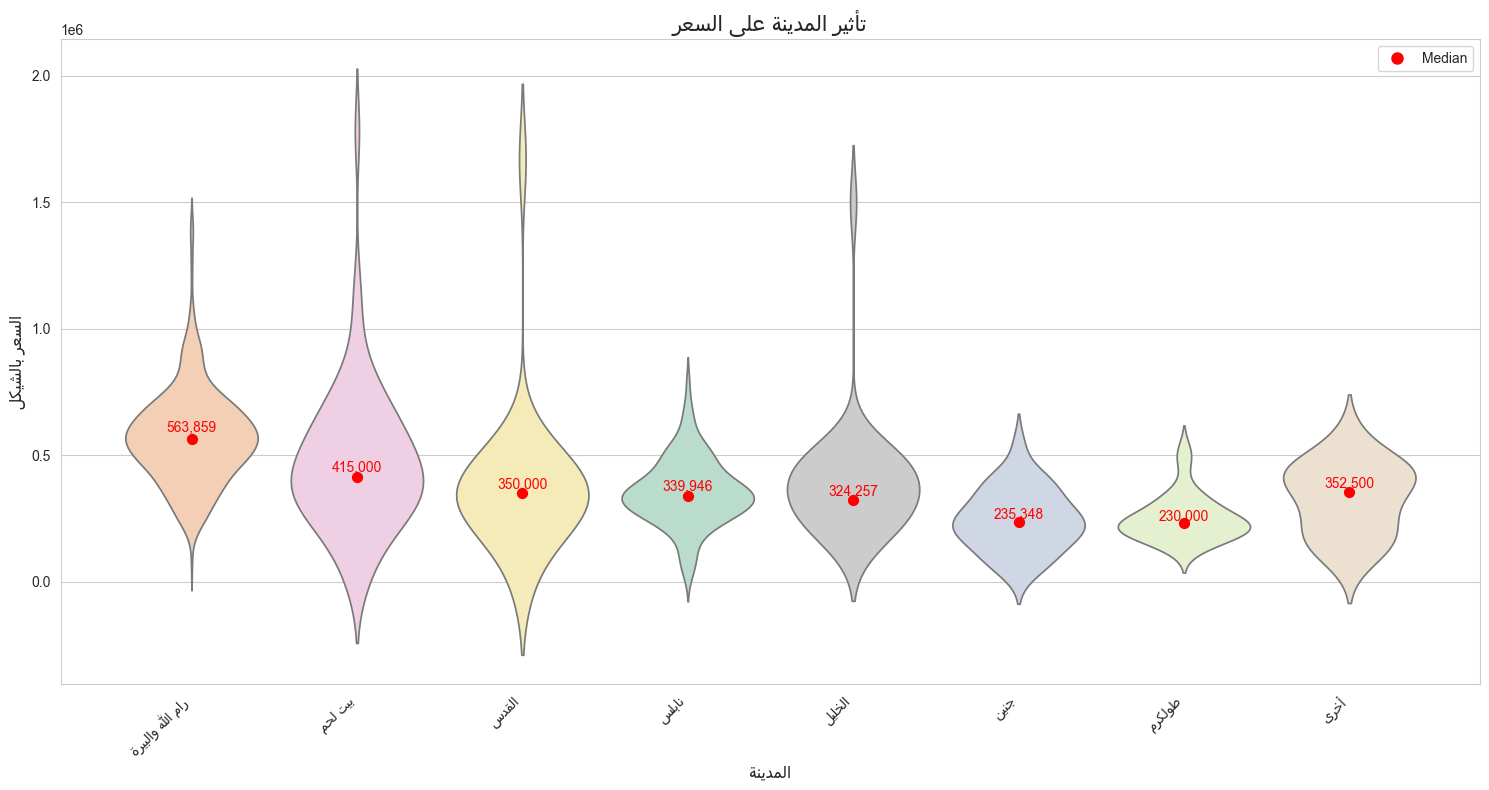

In [17]:
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'Arial Unicode MS'

# Group small cities into "Other"
city_counts = df['المدينة'].value_counts()
df['city_grouped'] = df['المدينة'].apply(lambda x: x if city_counts[x] >= 25 else 'أخرى')

# Order cities by median price
major_cities = df[df['city_grouped'] != 'أخرى'].groupby('city_grouped')['السعر بالشيكل'].median()
city_order = list(major_cities.sort_values(ascending=False).index) + ['أخرى']

processed_labels = [process_arabic_text(label) for label in city_order]

plt.figure(figsize=(15, 8))

sns.violinplot(
    data=df,
    x='city_grouped',
    y='السعر بالشيكل',
    order=city_order,
    palette="Pastel2",
    hue='city_grouped',
    inner=None,
    dodge=False,
    legend=False
)

# Overlay median points and annotate counts
medians = df.groupby('city_grouped')['السعر بالشيكل'].median()
counts = df['city_grouped'].value_counts()
for i, city in enumerate(city_order):
    median_val = medians[city]
    plt.scatter(i, median_val, color='red', s=50, zorder=10)
    plt.text(i, median_val + median_val * 0.05, f"{median_val:,.0f}",  # use comma separator, no decimals
             ha='center', color='red', weight='semibold')

import matplotlib.lines as mlines
median_dot = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=8, label='Median')
plt.legend(handles=[median_dot])

plt.title(process_arabic_text('تأثير المدينة على السعر'), fontsize=16)
plt.xlabel(process_arabic_text('المدينة'), fontsize=12)
plt.ylabel(process_arabic_text('السعر بالشيكل'), fontsize=12)
plt.xticks(ticks=range(len(processed_labels)), labels=processed_labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()

df.drop(columns=['city_grouped'], inplace=True)


C:\Users\user\AppData\Local\Temp\ipykernel_8640\621532509.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_no_outliers = df.groupby(feature, group_keys=False).apply(drop_outliers)


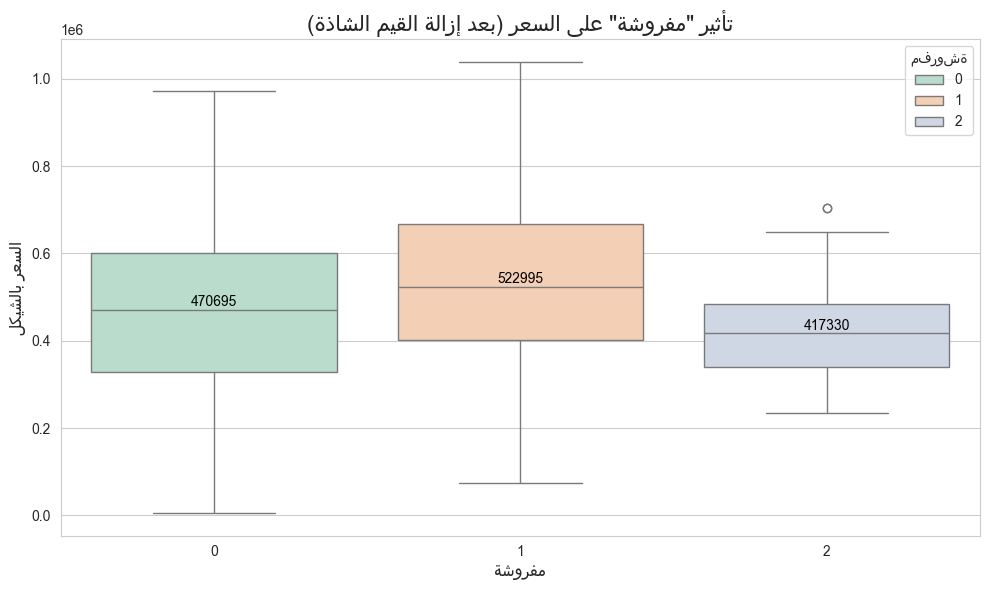

C:\Users\user\AppData\Local\Temp\ipykernel_8640\621532509.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_no_outliers = df.groupby(feature, group_keys=False).apply(drop_outliers)


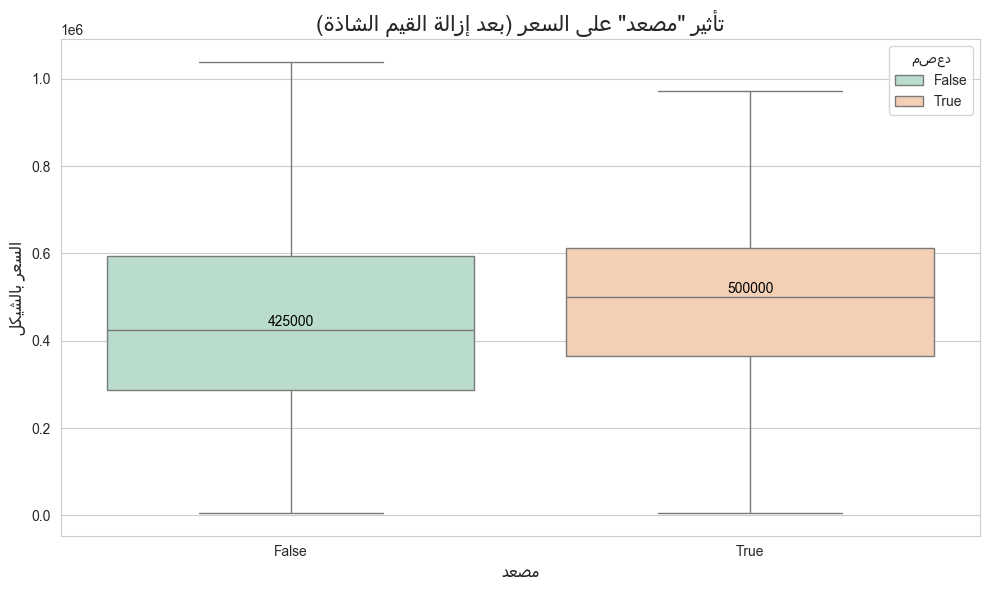

C:\Users\user\AppData\Local\Temp\ipykernel_8640\621532509.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_no_outliers = df.groupby(feature, group_keys=False).apply(drop_outliers)


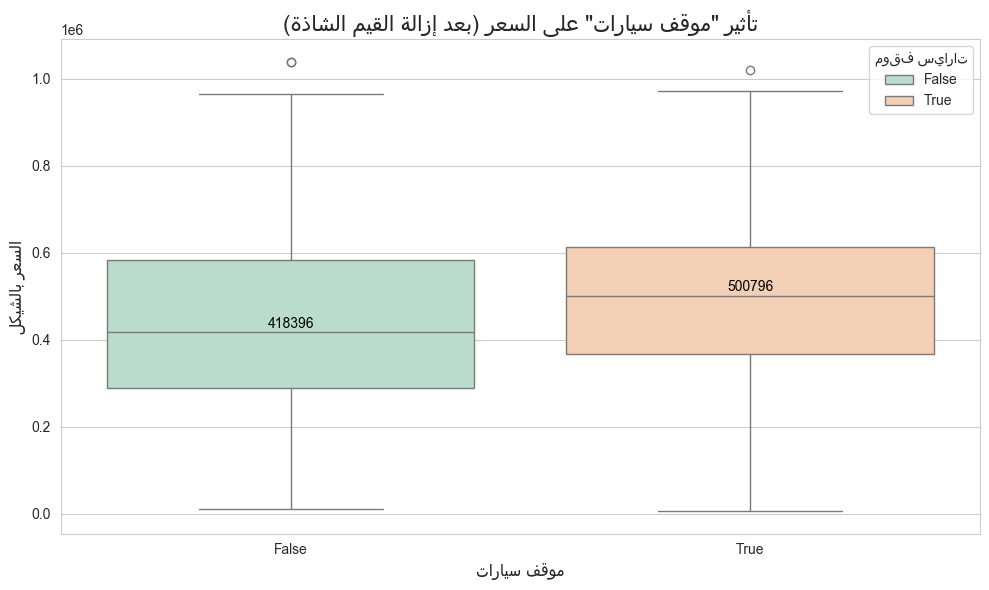

C:\Users\user\AppData\Local\Temp\ipykernel_8640\621532509.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_no_outliers = df.groupby(feature, group_keys=False).apply(drop_outliers)


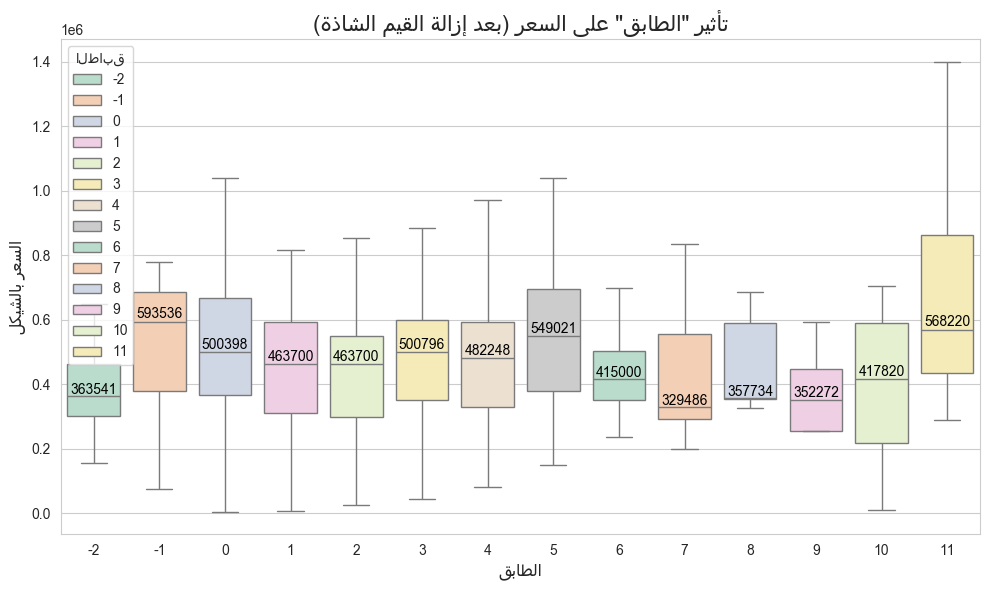

C:\Users\user\AppData\Local\Temp\ipykernel_8640\621532509.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_no_outliers = df.groupby(feature, group_keys=False).apply(drop_outliers)


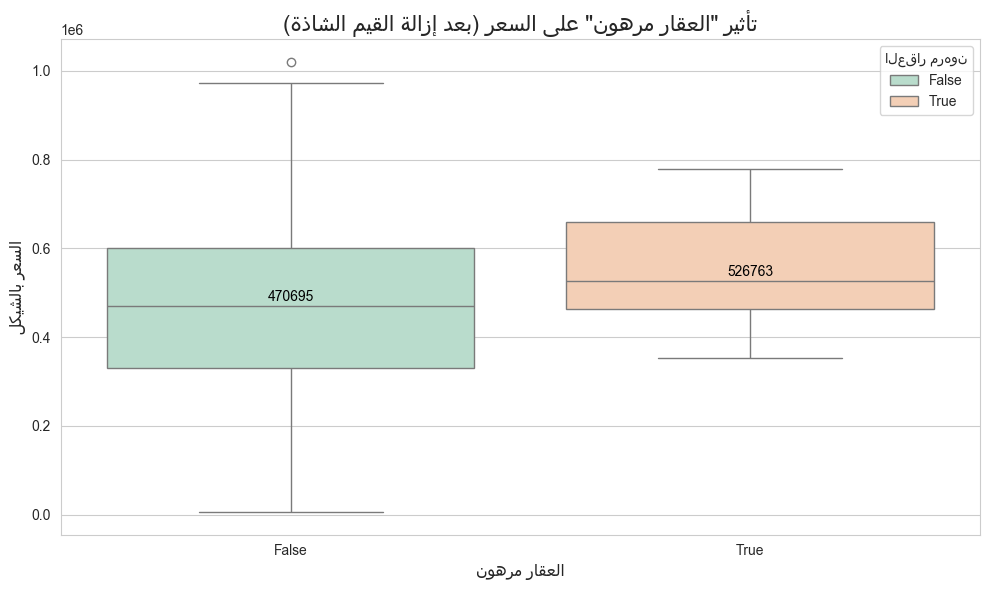

C:\Users\user\AppData\Local\Temp\ipykernel_8640\621532509.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_no_outliers = df.groupby(feature, group_keys=False).apply(drop_outliers)


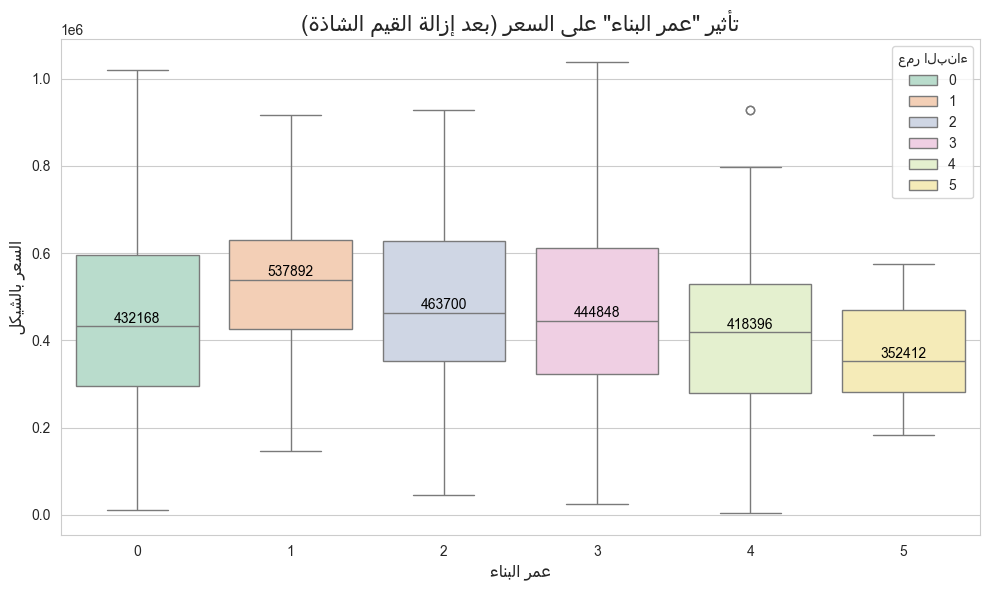

In [18]:
other_categorical_features = ['مفروشة', 'مصعد', 'موقف سيارات', 'الطابق', 'العقار مرهون', 'عمر البناء']

for feature in other_categorical_features:
    plt.figure(figsize=(10, 6))
    
    # Sort floor numerically
    order = sorted(df[feature].unique()) if feature == 'الطابق' else None
    
    # Drop outliers per category using IQR
    def drop_outliers(sub_df):
        Q1 = sub_df['السعر بالشيكل'].quantile(0.25)
        Q3 = sub_df['السعر بالشيكل'].quantile(0.75)
        IQR = Q3 - Q1
        return sub_df[(sub_df['السعر بالشيكل'] >= Q1 - 1.5*IQR) & 
                      (sub_df['السعر بالشيكل'] <= Q3 + 1.5*IQR)]
    
    df_no_outliers = df.groupby(feature, group_keys=False).apply(drop_outliers)
    
    ax = sns.boxplot(data=df_no_outliers, x=feature, y='السعر بالشيكل', order=order, palette="Pastel2", hue=feature)
    
    # Annotate medians
    medians = df_no_outliers.groupby(feature)['السعر بالشيكل'].median()
    for i, val in enumerate(order if order else medians.index):
        plt.text(i, medians[val] + medians[val]*0.02, f"{medians[val]:.0f}",
                 ha='center', color='black', weight='semibold')
    
    plt.title(process_arabic_text(f'تأثير "{feature}" على السعر (بعد إزالة القيم الشاذة)'), fontsize=16)
    plt.xlabel(process_arabic_text(feature), fontsize=12)
    plt.ylabel(process_arabic_text('السعر بالشيكل'), fontsize=12)
    plt.tight_layout()
    plt.show()


Based on our feature analysis, we've identified significant class imbalance in the city distribution. To address this in our modeling phase, we will implement:
- Bootstrap Sampling: Oversample properties from underrepresented cities to ensure adequate training representation.
- Gaussian Noise Augmentation: Add controlled variations to continuous features when duplicating samples to create realistic diversity while preserving the data relationships observed in our correlation analysis.
These techniques will help our model generalize better across all cities while maintaining the key feature relationships, particularly the strong correlations between area, bathrooms, and price.

In [19]:
df.to_csv('Apts.csv')